Protected Lands
===

This notebook merges FieldDoc protected lands with PASDA protected lands and plots the distribution of protection type in each cluster and subbasin.

### TODO: add description of where data comes from, including link to PASDA

# Setup

In [32]:
# Import packages
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [33]:
# Find your current working directory, which should be folder for this notebook.
Path.cwd()

PosixPath('/Users/aaufdenkampe/Documents/Python/pollution-assessment/stage2/Protected_Lands')

In [34]:
# Set your project directory to your local folder for your clone of this repository
project_path = Path.cwd().parent.parent
project_path

PosixPath('/Users/aaufdenkampe/Documents/Python/pollution-assessment')

In [35]:
# Path to WeConservePA protected lands shapefile
wcpa_path = project_path / Path('stage2/Protected_Lands/WeConservePA_pl_20220810.shp')
wcpa_path.exists()

True

In [36]:
# Path to FieldDoc protected lands export file
fielddoc_path = project_path / Path('stage2/private/protection_df.parquet')
fielddoc_path.exists()

True

# Load data

## From WeConservePA

In [108]:
# Import weconservePA protected lands
wcpa_gdf = gpd.read_file(wcpa_path)

wcpa_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 22137 entries, 0 to 22136
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    22137 non-null  int64   
 1   Category    22137 non-null  object  
 2   sitename    21956 non-null  object  
 3   esmthldr    8877 non-null   object  
 4   eholdtype   8868 non-null   object  
 5   own_name    13258 non-null  object  
 6   own_type    18637 non-null  object  
 7   URL         20702 non-null  object  
 8   purpose     18507 non-null  object  
 9   year_est    22137 non-null  int64   
 10  gis_acres   22137 non-null  float64 
 11  pubaccess   22015 non-null  object  
 12  Landscape   911 non-null    object  
 13  Cluster     9355 non-null   object  
 14  LTSA        22115 non-null  object  
 15  WTRSA       18649 non-null  object  
 16  State_abb   22127 non-null  object  
 17  State       22127 non-null  object  
 18  County      22127 non-null  object  
 

In [117]:
# Add data source tag
wcpa_gdf['data_source'] = 'weconservePA'

### TODO: Convert Object to Category dtype

In [119]:
wcpa_dtypes = {
    'Category':'category',
    'State':'category',
    'RECLASS2':'category',
}

In [120]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html

wcpa_gdf = wcpa_gdf.astype(wcpa_dtypes)

In [121]:
wcpa_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 22137 entries, 0 to 22136
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   OBJECTID     22137 non-null  int64   
 1   Category     22137 non-null  category
 2   sitename     21956 non-null  object  
 3   esmthldr     8877 non-null   object  
 4   eholdtype    8868 non-null   object  
 5   own_name     13258 non-null  object  
 6   own_type     18637 non-null  object  
 7   URL          20702 non-null  object  
 8   purpose      18507 non-null  object  
 9   year_est     22137 non-null  int64   
 10  gis_acres    22137 non-null  float64 
 11  pubaccess    22015 non-null  object  
 12  Landscape    911 non-null    object  
 13  Cluster      9355 non-null   object  
 14  LTSA         22115 non-null  object  
 15  WTRSA        18649 non-null  object  
 16  State_abb    22127 non-null  object  
 17  State        22127 non-null  category
 18  County       22127

In [122]:
wcpa_gdf.RECLASS2.unique()

['Agricultural Easement', 'Conservation Easement', 'Park or Recreation Area - Federal', 'National Resource Area - Federal', 'Natural Resource Area - Federal', ..., 'Park or Recreation Area - Local', 'National Resource Area - Private', 'Park or Recreation Area - Private', 'Park or Recreation Area - State', 'National Resource Area - State']
Length: 11
Categories (11, object): ['Agricultural Easement', 'Conservation Easement', 'National Resource Area - Federal', 'National Resource Area - Local', ..., 'Park or Recreation Area - Federal', 'Park or Recreation Area - Local', 'Park or Recreation Area - Private', 'Park or Recreation Area - State']

In [162]:
# Rename categories with typos
# https://pandas.pydata.org/docs/reference/api/pandas.Series.cat.rename_categories.html
wcpa_gdf.RECLASS2.cat.rename_categories(
    {'National Resource Area - State': 'Natural Resource Area - State',  
     'National Resource Area - Local': 'Natural Resource Area - Local', 
     'National Resource Area - Private': 'Natural Resource Area - Private'            
    },
    inplace=True,
)

# NOTE: this one isn't unique, so must be corrected in shapefile: 'National Resource Area - Federal': 'Natural Resource Area - Federal',

wcpa_gdf.RECLASS2.unique()

/var/folders/tx/14mbtmrs0rq2b6mkfxdh54r00000gp/T/ipykernel_30469/1374914805.py:3: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  wcpa_gdf.RECLASS2.cat.rename_categories(


['Agricultural Easement', 'Conservation Easement', 'Park or Recreation Area - Federal', 'National Resource Area - Federal', 'Natural Resource Area - Federal', ..., 'Park or Recreation Area - Local', 'Natural Resource Area - Private', 'Park or Recreation Area - Private', 'Park or Recreation Area - State', 'Natural Resource Area - State']
Length: 11
Categories (11, object): ['Agricultural Easement', 'Conservation Easement', 'National Resource Area - Federal', 'Natural Resource Area - Local', ..., 'Park or Recreation Area - Federal', 'Park or Recreation Area - Local', 'Park or Recreation Area - Private', 'Park or Recreation Area - State']

In [130]:
# Convert shape area from m^2 to acres
wcpa_gdf['Area_Ac'] = wcpa_gdf['Shape_Area']/4046.86
wcpa_gdf.head(n=1)

,OBJECTID,Category,sitename,esmthldr,eholdtype,own_name,own_type,URL,purpose,year_est,...,Municipali,Muni_Type,Muni,MMW,Shape_Leng,Shape_Area,RECLASS2,geometry,data_source,Area_Ac
0,1,Government Agricultural Easement,A & A Likanchuk Enterprises,Cumberland County,Local,None,Private,http://www.co.cumberland.nj.us/content/22602/2...,Open Space - Farm,2019,...,Hopewell Township,Township,None,Agricultural Easement,3423.049486,187004.776462,Agricultural Easement,"POLYGON ((1751532.341 407777.856, 1751099.644 ...",weconservePA,46.209846


In [131]:
# maybe rename old column instead?
wcpa_gdf[['gis_acres', 'Area_Ac']]

,gis_acres,Area_Ac
0,46.209891,46.209846
1,49.392749,49.392700
2,15.743589,15.743574
3,168.223510,168.223344
4,26.857754,26.857727
...,...,...
22132,121.784450,121.784330
22133,1224.569510,1224.568299
22134,618.064921,618.064310
22135,154.353005,154.352852


## From FieldDoc

In [133]:
# Import FieldDoc protected lands 
fielddoc_gdf = gpd.read_parquet(fielddoc_path)

# Add a column to fielddoc_gdf with data source
fielddoc_gdf['data_source'] = 'fielddoc_2022-08-11'
fielddoc_gdf.head(n=1)

,,huc12,practice_name,program_name,program_id,organization,description,practice_type,created_at,modified_at,bmp_size,bmp_size_unit,geom,data_source
comid,practice_id,,,,,,,,,,,,,
2583191,54313,020401050101,Culvers Brook Preserve II - Subject - Fee Acqu...,Delaware River Watershed Protection Fund - For...,5,New Jersey Conservation Foundation,None,Fee acquisition,2021-11-23 21:16:32.491086+00:00,2021-12-07 14:29:21.209918+00:00,8.52,ACRES,"MULTIPOLYGON (((-74.75218 41.16936, -74.75349 ...",fielddoc_2022-08-11


In [134]:
fielddoc_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 313 entries, (2583191, 54313) to (932040274, 42239)
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   huc12          313 non-null    category           
 1   practice_name  313 non-null    category           
 2   program_name   313 non-null    category           
 3   program_id     313 non-null    int64              
 4   organization   313 non-null    category           
 5   description    313 non-null    category           
 6   practice_type  313 non-null    category           
 7   created_at     313 non-null    datetime64[ns, UTC]
 8   modified_at    313 non-null    datetime64[ns, UTC]
 9   bmp_size       313 non-null    float64            
 10  bmp_size_unit  313 non-null    category           
 11  geom           313 non-null    geometry           
 12  data_source    313 non-null    object             
dtypes: category(

In [152]:
list(fielddoc_gdf.program_name.unique())

['Delaware River Watershed Protection Fund - Forestland Capital Grants',
 'Delaware River Watershed Protection Fund - Transaction Grants']

In [136]:
fielddoc_gdf.practice_type.unique()

['Fee acquisition', 'Conservation easement']
Categories (2, object): ['Conservation easement', 'Fee acquisition']

In [153]:
fielddoc_gdf.practice_type.cat.rename_categories(
    {'Conservation easement': 'DRWI Conservation easement', 
     'Fee acquisition': 'DRWI Fee acquisition',
    },
    inplace=True,
)

/var/folders/tx/14mbtmrs0rq2b6mkfxdh54r00000gp/T/ipykernel_30469/3402620491.py:1: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  fielddoc_gdf.practice_type.cat.rename_categories(


## For DRWI Geographies

In [137]:
# Import cluster and focus area geometries
cluster_gdf = gpd.read_parquet(project_path / Path('stage1/data/cluster_df.parquet'))  
focusarea_gdf = gpd.read_parquet(project_path / Path('stage1/data/fa_phase2_df.parquet'))

focusarea_gdf.cluster = focusarea_gdf.cluster.replace('Kirkwood Cohansey Aquifer', 'Kirkwood - Cohansey Aquifer') # update name for consistency with other files 
focusarea_gdf.set_index('name', inplace=True)

In [138]:
cluster_gdf.head()

,gid,objectid,label_id,sum_acres,acres,ncontrb_a,acres_ans,name,shape_leng,shape_area,geom
labels,,,,,,,,,,,
Poconos and Kittatinny,1,0,5,866281.173581,866281.173581,865592.657330,865593,Poconos and Kittatinny,5.179372,0.368441,"MULTIPOLYGON (((511922.413 4619793.062, 511948..."
Middle Schuylkill,2,0,3,501873.916855,501873.916855,501532.547416,501533,Middle Schuylkill,0.000000,0.000000,"MULTIPOLYGON (((398250.125 4483059.000, 398241..."
Brandywine and Christina,3,0,1,360524.071274,360524.071274,360270.075107,360270,Brandywine and Christina,0.000000,0.000000,"MULTIPOLYGON (((448782.249 4434220.000, 448840..."
New Jersey Highlands,4,0,4,441794.273605,441794.273605,441441.637355,441442,New Jersey Highlands,0.000000,0.000000,"MULTIPOLYGON (((486254.217 4533019.500, 486403..."
Schuylkill Highlands,5,0,6,109186.312480,109186.312480,109107.796416,109108,Schuylkill Highlands,0.000000,0.000000,"MULTIPOLYGON (((445764.281 4456450.500, 445828..."


In [139]:
focusarea_gdf.head()

,cluster,strategy,nord,phase,geom,change,tier,subfocusare,area_acres,name_final,geom_buff
name,,,,,,,,,,,
Brandywine Creek Headwaters,Brandywine and Christina,restoration,1165,Phase 2,"MULTIPOLYGON (((424032.708 4440256.746, 424029...",None,None,None,11800.8328,Brandywine Creek Headwaters,01060000206A7F000001000000010300000001000000AE...
Plum Run,Brandywine and Christina,restoration,928,Phase 2,"MULTIPOLYGON (((446401.966 4418305.792, 446394...",None,None,None,2380.8159,Plum Run,01060000206A7F000001000000010300000001000000EE...
Red Clay Creek,Brandywine and Christina,restoration,1469,Phase 2,"MULTIPOLYGON (((441020.876 4413254.885, 440973...",None,None,None,6968.2479,Red Clay Creek,01060000206A7F0000010000000103000000010000003B...
White Clay Creek,Brandywine and Christina,restoration,1351,Phase 2,"MULTIPOLYGON (((430499.059 4416244.890, 430498...",None,None,None,10654.6468,White Clay Creek,01060000206A7F000001000000010300000001000000C2...
Cohansey River,Kirkwood - Cohansey Aquifer,restoration,14605,Phase 2,"MULTIPOLYGON (((478620.866 4369649.016, 478591...",None,None,None,26857.2196,Cohansey River,01060000206A7F0000010000000103000000010000007A...


# Reproject coordinate systems

In [140]:
# Check coordinate systems
wcpa_gdf.crs

<Derived Projected CRS: ESRI:102003>
Name: USA_Contiguous_Albers_Equal_Area_Conic
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [141]:
fielddoc_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [142]:
# Reproject CRS to 3857
wcpa_gdf.to_crs(epsg=3857, inplace=True)
fielddoc_gdf.to_crs(epsg=3857, inplace=True)
focusarea_gdf.to_crs(epsg=3857, inplace=True)
cluster_gdf.to_crs(epsg=3857, inplace=True)

<AxesSubplot:>

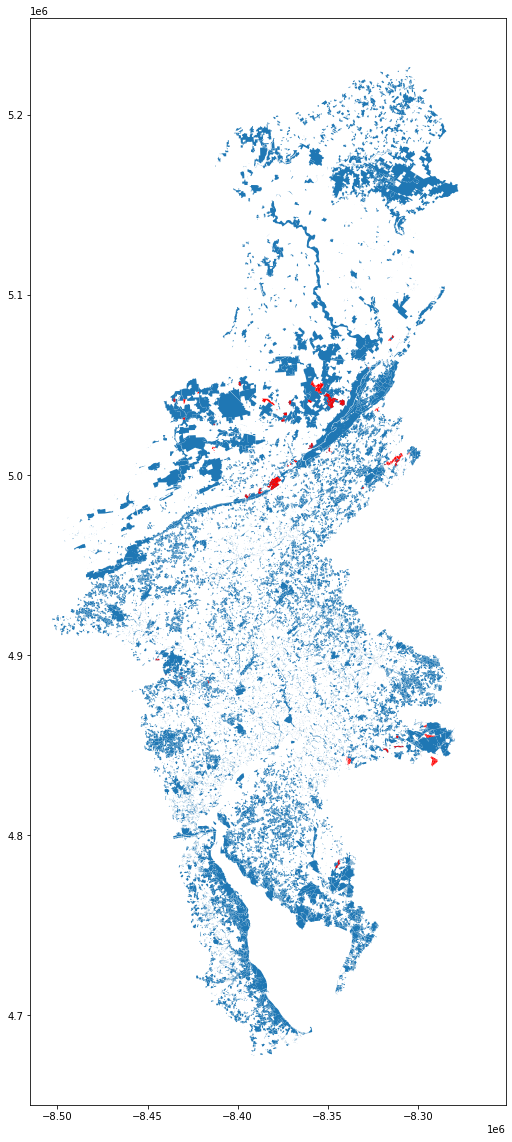

In [143]:
# Plot weconservePA and fielddoc protected lands 
plt.rcParams["figure.figsize"] = (20,20)
fig, ax1 = plt.subplots()
wcpa_gdf.plot(ax=ax1)
cmap = ListedColormap(['red'],name='allred')
fielddoc_gdf.plot(ax=ax1,cmap=cmap)

# Merge geodataframes

## Subtract field doc lands from weconservePA to remove any overlap

In [163]:
# Subtract field doc lands from weconservePA lands
dif_gdf = wcpa_gdf.overlay(fielddoc_gdf, how='difference', keep_geom_type=False)

<AxesSubplot:>

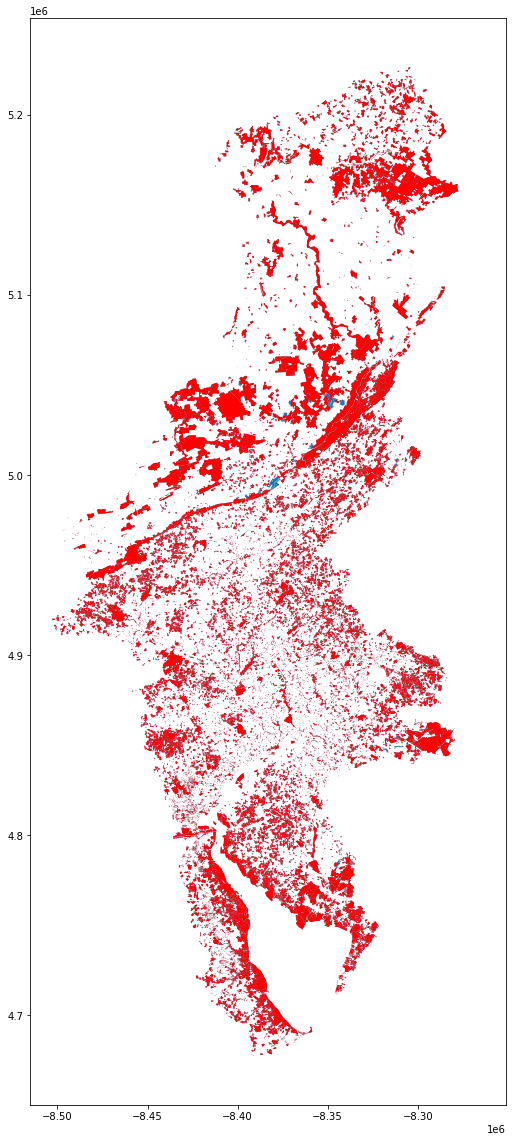

In [164]:
# Plot original weconservePA data against difference gdf
plt.rcParams["figure.figsize"] = (20,20)
fig, ax1 = plt.subplots()
wcpa_gdf.plot(ax=ax1)
cmap = ListedColormap(['red'],name='allred')
dif_gdf.plot(ax=ax1,cmap=cmap)

## Append field doc with weconservePA protected lands

In [165]:
# Clean up column headers to match in merge
wcpa_simp_gdf = dif_gdf[['sitename','esmthldr','purpose','RECLASS2','data_source','Area_Ac','geometry']]
wcpa_simp_gdf.rename(
    columns={
        'sitename': 'practice_name', 
        'purpose': 'description',
        'esmthldr': 'organization', 
        'RECLASS2': 'practice_type',
        'geometry': 'geom'
    }, 
    inplace=True
)

fielddoc_gdf.rename(columns={'bmp_size': 'Area_Ac'}, inplace=True)

/var/folders/tx/14mbtmrs0rq2b6mkfxdh54r00000gp/T/ipykernel_30469/2445324670.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wcpa_simp_gdf.rename(


In [166]:
# Append field doc protected lands with pasda protected lands
all_pl_gdf = fielddoc_gdf.append(wcpa_simp_gdf)
all_pl_gdf.head(n=1)

# Clean up all protected land gdf
#all_pl_gdf = all_pl_gdf[['practice_name', 'program_name', 'organization','practice_type', 'data_source', 'geom']]

/var/folders/tx/14mbtmrs0rq2b6mkfxdh54r00000gp/T/ipykernel_30469/2924458830.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_pl_gdf = fielddoc_gdf.append(wcpa_simp_gdf)


,huc12,practice_name,program_name,program_id,organization,description,practice_type,created_at,modified_at,Area_Ac,bmp_size_unit,geom,data_source
"(2583191, 54313)",020401050101,Culvers Brook Preserve II - Subject - Fee Acqu...,Delaware River Watershed Protection Fund - For...,5.0,New Jersey Conservation Foundation,None,DRWI Fee acquisition,2021-11-23 21:16:32.491086+00:00,2021-12-07 14:29:21.209918+00:00,8.52,ACRES,"MULTIPOLYGON (((-8321374.316 5037354.416, -832...",fielddoc_2022-08-11


In [186]:
# Compute area after append to ensure no overlaps were included
all_pl_gdf['Final_Area_Ac'] = all_pl_gdf.geometry.area/4046


# NOTE: values are not correct!
all_pl_gdf[['Area_Ac', 'Final_Area_Ac']]

,Area_Ac,Final_Area_Ac
"(2583191, 54313)",8.520000,15.069824
"(2583195, 51275)",6.080000,10.740518
"(2583195, 51282)",4.640000,8.207957
"(2583195, 54313)",171.070000,302.409673
"(2583199, 51275)",18.950000,33.506189
...,...,...
22132,121.784330,214.397280
22133,1224.568299,2154.802186
22134,618.064310,1087.548259
22135,154.352852,271.691187


### ERROR: values are not correct for 'Final_Area_Ac'

# Plot distribution of protected lands

## By Cluster

In [169]:
cluster_gdf.index

CategoricalIndex(['Poconos and Kittatinny', 'Middle Schuylkill',
                  'Brandywine and Christina', 'New Jersey Highlands',
                  'Schuylkill Highlands', 'Upstream Suburban Philadelphia',
                  'Kirkwood - Cohansey Aquifer', 'Upper Lehigh'],
                 categories=['Brandywine and Christina', 'Kirkwood - Cohansey Aquifer', 'Middle Schuylkill', 'New Jersey Highlands', 'Poconos and Kittatinny', 'Schuylkill Highlands', 'Upper Lehigh', 'Upstream Suburban Philadelphia'], ordered=False, dtype='category', name='labels')

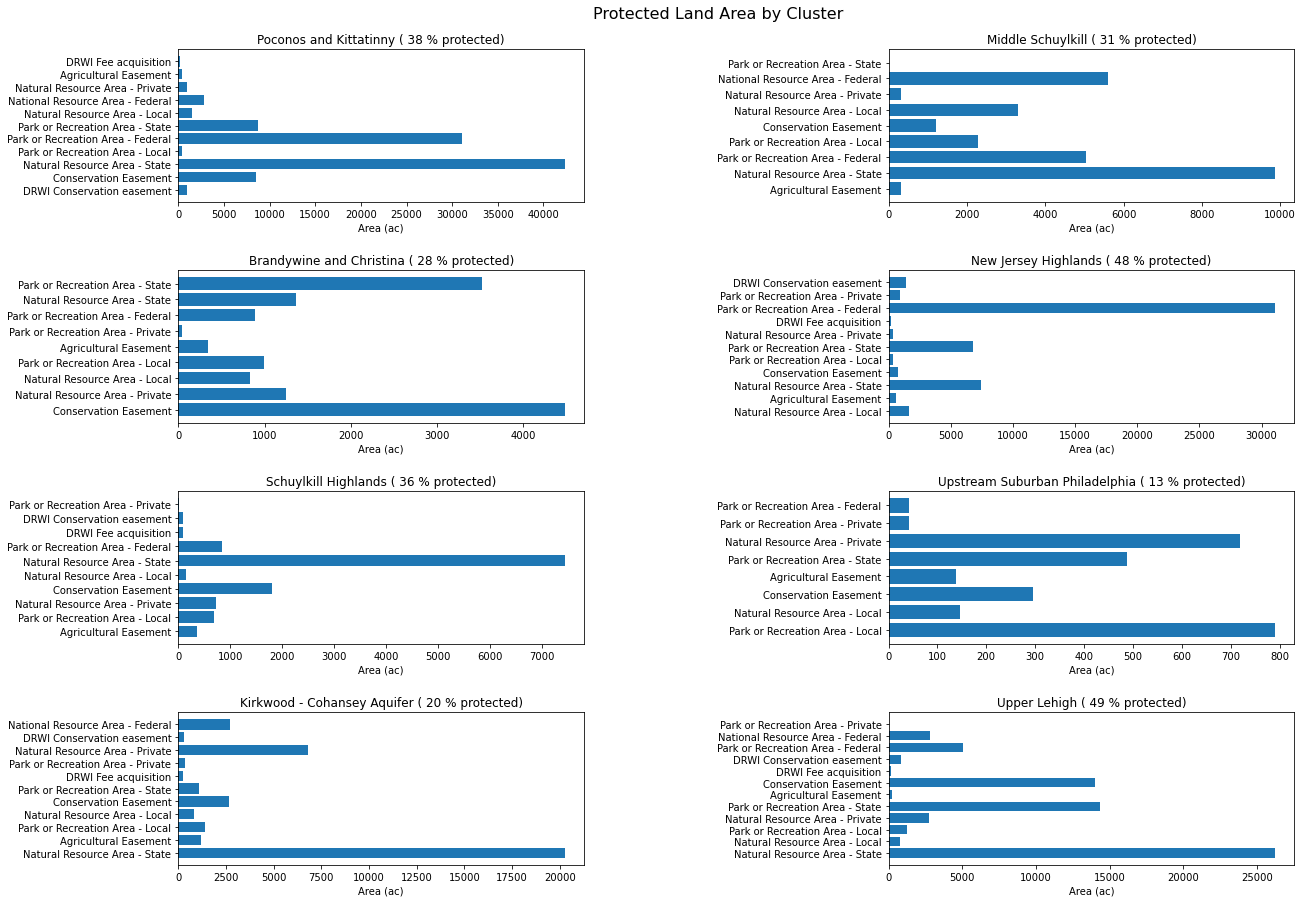

In [187]:
# Plot distribution of protected land area for each cluster
fig, ax = plt.subplots(4,2, figsize=(20,15))
plt.subplots_adjust(hspace=0.45,wspace=0.75)
fig.suptitle('Protected Land Area by Cluster',fontsize=16,y=0.92)
n=0

for cluster in cluster_gdf.index:
    geom = cluster_gdf.loc[[cluster]]
    in_cluster = all_pl_gdf.clip(geom)
    n = n+1
    ax = plt.subplot(4,2,n)
    plt.xlabel('Area (ac)')
    
    # Calculate protected fraction of total area
    cluster_acres = cluster_gdf.at[cluster,'acres']
    protected_acres = in_cluster['Area_Ac'].sum()
    protected_percent = 100 * protected_acres / cluster_acres

    plt.title(f'{cluster} ({protected_percent: .0f} % protected)')
    
    plt.barh(in_cluster['practice_type'], width=in_cluster['Area_Ac'])

In [185]:
in_cluster

,huc12,practice_name,program_name,program_id,organization,description,practice_type,created_at,modified_at,Area_Ac,bmp_size_unit,geom,data_source,Final_Area_Ac
20327,NaN,SGL 038,NaN,NaN,None,State Game Land,Natural Resource Area - State,NaT,NaT,5574.831075,NaN,"MULTIPOLYGON (((-8394419.673 5021087.609, -839...",weconservePA,9808.938749
20246,NaN,Delaware State Forest,NaN,NaN,None,State Forest,Natural Resource Area - State,NaT,NaT,2.863407,NaN,"POLYGON ((-8395032.775 5026647.774, -8395210.4...",weconservePA,5.047818
14432,NaN,WB&E Rail Bed,NaN,NaN,None,Local Land,Natural Resource Area - Local,NaT,NaT,16.126435,NaN,"POLYGON ((-8394881.386 5027090.289, -8394899.3...",weconservePA,28.429306
14502,NaN,Hemlock Sanctuary,NaN,NaN,None,Local Conservation Area,Natural Resource Area - Local,NaT,NaT,33.479221,NaN,"POLYGON ((-8391254.253 5035698.989, -8391431.3...",weconservePA,59.132448
13580,NaN,Laurel Drive Coobaugh Township Park,NaN,NaN,None,Community Park,Park or Recreation Area - Local,NaT,NaT,31.954035,NaN,"POLYGON ((-8393285.046 5037766.505, -8393154.4...",weconservePA,56.458456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22085,NaN,State Game Land 217,NaN,NaN,None,State Game Land,Natural Resource Area - State,NaT,NaT,220.680050,NaN,"POLYGON ((-8436850.044 4971739.852, -8436870.0...",weconservePA,384.635999
22074,NaN,State Game Land 217,NaN,NaN,None,State Game Land,Natural Resource Area - State,NaT,NaT,115.911242,NaN,"POLYGON ((-8447514.172 4965254.893, -8447241.2...",weconservePA,201.804867
22117,NaN,State Game Land 217,NaN,NaN,None,State Game Land,Natural Resource Area - State,NaT,NaT,125.043175,NaN,"POLYGON ((-8446320.812 4965985.657, -8446326.4...",weconservePA,217.739637
22116,NaN,State Game Land 217,NaN,NaN,None,State Game Land,Natural Resource Area - State,NaT,NaT,57.640566,NaN,"MULTIPOLYGON (((-8444853.688 4966673.376, -844...",weconservePA,100.377959


In [180]:
in_cluster['practice_type'].sort_values()

3494               Agricultural Easement
3504               Agricultural Easement
3489               Agricultural Easement
3506               Agricultural Easement
3509               Agricultural Easement
                      ...               
20353    Park or Recreation Area - State
20361    Park or Recreation Area - State
20363    Park or Recreation Area - State
20354    Park or Recreation Area - State
20358    Park or Recreation Area - State
Name: practice_type, Length: 425, dtype: object

## By Focus Area

In [51]:
focusarea_gdf.index

Index(['Brandywine Creek Headwaters', 'Plum Run', 'Red Clay Creek',
       'White Clay Creek', 'Cohansey River', 'Lower Salem River', 'Menantico',
       'Muddy Run', 'Rancocas', 'Upper Salem River', 'Furnace Cr',
       'Hosensack Cr', 'Licking Cr', 'Lower Maiden Cr Trib 1',
       'Lower Maiden Cr Trib 3', 'Manatawny Trib 2', 'Manatawny Trib 3',
       'Manor Cr', 'Mill Cr Berger', 'Mill Cr Trib 2', 'Mill Cr Younker',
       'Moselem Cr', 'Tulpehocken Trib 2', 'Tulpehocken Trib 3',
       'Little Manatawny Trib 4', 'Lower Maiden Cr Trib 2',
       'Middle Maiden Trib', 'Northkill', 'Saucony Cr Trib 1',
       'Saucony Cr Trib 2', 'Beaver Brook', 'Lopatcong Creek',
       'Lower Middle Musconetcong', 'Paulinskill', 'Upper Musconetcong',
       'Brodhead', 'Cherry Valley', 'Eastern Mongaup', 'Little Bushkill',
       'Lower Bashakill', 'Lower Neversink', 'Rattlesnake Creek',
       'Upper Neversink', 'Hay Creek', 'Bryn Coed', 'Pigeon Run',
       'Pine Creek - French', 'Pine Creek - Pi

CPU times: user 52.7 s, sys: 145 ms, total: 52.9 s
Wall time: 53 s


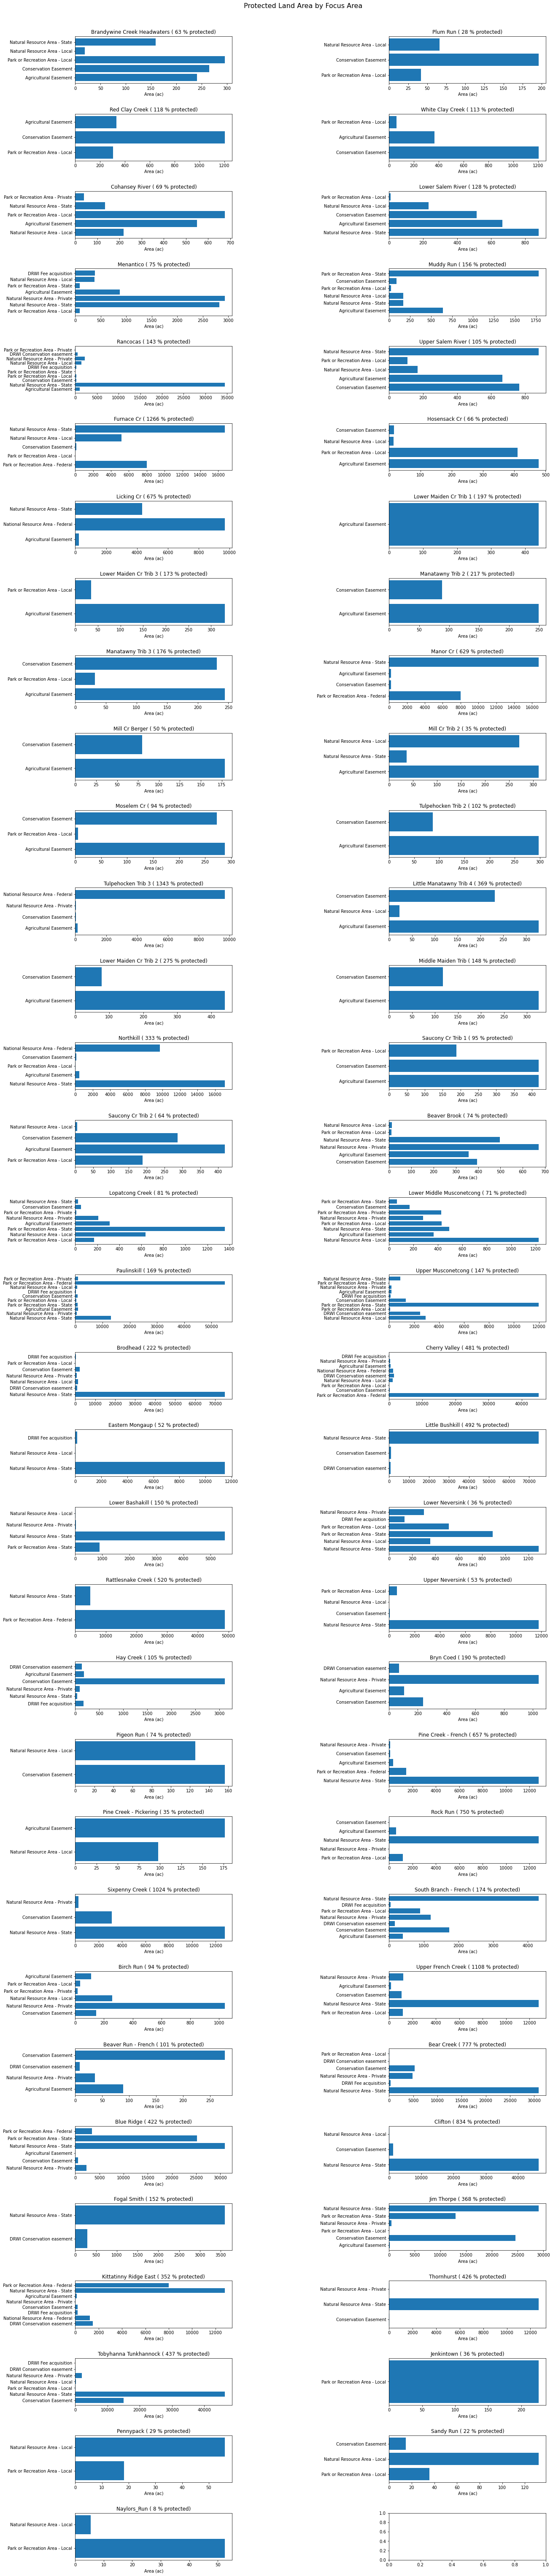

In [183]:
%%time
# Plot distribution of protected land area for each focus area
fig, ax = plt.subplots(33,2, figsize=(20,110))
plt.subplots_adjust(hspace=0.65,wspace=1)
fig.suptitle('Protected Land Area by Focus Area',fontsize=16,y=0.89)
n=0

for focusarea in focusarea_gdf.index:
    geom = focusarea_gdf.loc[[focusarea]]
    in_fa = all_pl_gdf.clip(geom)
    
    if in_fa.size != 0:
        n = n+1
        ax = plt.subplot(33,2,n) 
        plt.xlabel('Area (ac)')

        # Calculate protected fraction of total area
        # NOTE: This is clearly producing incorrect values!!
        fa_acres = focusarea_gdf.at[focusarea,'area_acres']
        protected_acres = in_fa['Area_Ac'].sum()
        protected_percent = 100 * protected_acres / fa_acres
        
        plt.title(f'{focusarea} ({protected_percent: .0f} % protected)')
        
        plt.barh(in_fa['practice_type'], width=in_fa['Area_Ac'])

In [184]:
in_fa

,huc12,practice_name,program_name,program_id,organization,description,practice_type,created_at,modified_at,Area_Ac,bmp_size_unit,geom,data_source,Final_Area_Ac
13499,NaN,Veterans Park,NaN,NaN,None,Neighborhood Park,Park or Recreation Area - Local,NaT,NaT,8.628547,NaN,"POLYGON ((-8382916.004 4862457.996, -8383033.6...",weconservePA,14.714524
12667,NaN,Bailey Park,NaN,NaN,None,Neighborhood Park,Park or Recreation Area - Local,NaT,NaT,4.739661,NaN,"POLYGON ((-8383423.963 4862744.292, -8383364.2...",weconservePA,8.082852
16930,NaN,Municipal Land,NaN,NaN,None,Local Land,Natural Resource Area - Local,NaT,NaT,3.218696,NaN,"POLYGON ((-8383752.405 4863228.814, -8383952.0...",weconservePA,5.489837
13473,NaN,Lawrence Road Park,NaN,NaN,None,Mini-Park,Park or Recreation Area - Local,NaT,NaT,0.779997,NaN,"POLYGON ((-8384693.258 4863547.143, -8384690.6...",weconservePA,1.330403
12775,NaN,Grasslyn Park,NaN,NaN,None,Neighborhood Park,Park or Recreation Area - Local,NaT,NaT,1.924496,NaN,"POLYGON ((-8383752.058 4863689.043, -8383707.5...",weconservePA,3.282569
12671,NaN,Beverly Hills Recreation Area,NaN,NaN,None,Neighborhood Park,Park or Recreation Area - Local,NaT,NaT,19.484269,NaN,"POLYGON ((-8379345.401 4859027.716, -8379067.0...",weconservePA,33.202580
12653,NaN,Naylor's Run Park,NaN,NaN,None,Community Park,Park or Recreation Area - Local,NaT,NaT,30.758202,NaN,"POLYGON ((-8380415.637 4860127.920, -8380316.6...",weconservePA,52.421769
12716,NaN,Drexel Gardens Park,NaN,NaN,None,Neighborhood Park,Park or Recreation Area - Local,NaT,NaT,13.812028,NaN,"POLYGON ((-8381262.067 4860275.248, -8381195.8...",weconservePA,23.543009
16911,NaN,Municipal Land,NaN,NaN,None,Local Land,Natural Resource Area - Local,NaT,NaT,0.194073,NaN,"POLYGON ((-8381838.448 4860346.204, -8381824.2...",weconservePA,0.330807
12717,NaN,Westview Play Area,NaN,NaN,None,Mini-Park,Park or Recreation Area - Local,NaT,NaT,0.715733,NaN,"POLYGON ((-8380537.366 4860367.517, -8380513.2...",weconservePA,1.220010
